In [1]:
import numpy as np

from skimage.io import imread
from skimage.color import rgb2gray

from matplotlib import pyplot as plt

from tqdm import trange
from tqdm.auto import tqdm

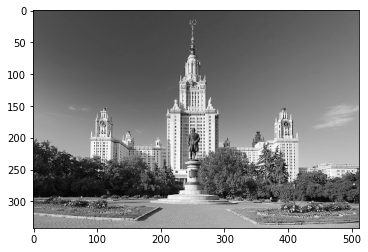

In [5]:
img_f32 = imread('msu.jpg').astype(np.float32) / 255.

gray_f32 = rgb2gray(img_f32)

plt.imshow(gray_f32, cmap='gray')
plt.show()

### Работа с гистограммой цветов

Гистограмма изображения позволяет оценить количество и разнообразие оттенков, а также общий уровень яркости. Гистограмма изображения не описывает художественных качеств, но с её помощью можно рассчитывать разные статистики в картинке. Например найти миниум, максимум, среднее, медиану.

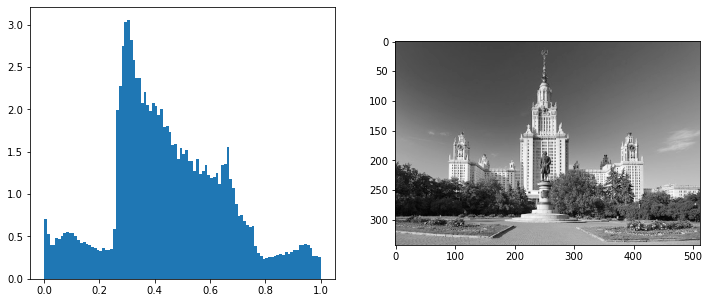

In [6]:
def plot_image_with_hist(image):
    # flatten image cause in image's histogram
    # there is no need to keep geometric information
    values = image.ravel()
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(values, bins=100, density=True)
    
    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray')
    
plot_image_with_hist(gray_f32)

Самым простым видом трансформаций цветовых компотент изображений являются точечные операторы, которые изменяют каждый пиксель независимо. Например повысить яркость картинки можно прибавив к каждому пикселю положительную константу и затем взять минимум с 255, максимальным значением пикселя в RGB картинке. $$ value = \min(255, value + 16) $$

Можно выделить общую форму для всех операторов преобразования изображений, как функцию от одной или более картинок, которая отображает аргументы в итоговую картинку. $$ y = g(x_{0}, x_{1}, ..., x_{n}) $$

#### Гамма-коррекция

$$ y = g(x) = x^{\gamma} $$


Во времена черно-белых телевизоров фосфор в электронно-лучевых трубках нелинейно реагировал на входное напряжение. Отношение между входным напряжением и получающейся яркостью можно было описать гаммой $ \gamma $, поскольку с грубой оценкой выполнялось $$ brightness = voltage^{\gamma}. $$ Где $ \gamma = 2.2 $. 
Чтобы обратить этот эффект телевизоры перед подачей кадра обрабатывали его через $$ Y' = Y^{\frac{1}{\gamma}}, $$
$$ \dfrac{1}{\gamma} = 0.45. $$


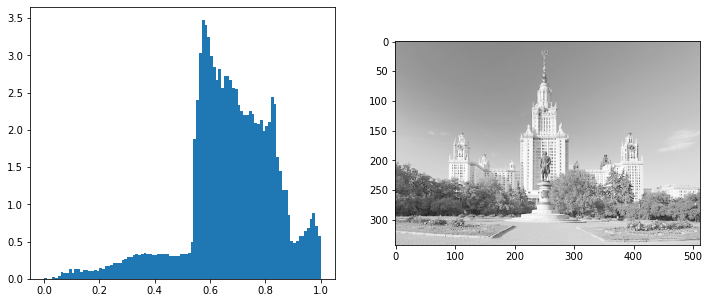

In [8]:
gamma = 1 / 2.2

gamma_correction = gray_f32 ** gamma

plot_image_with_hist(gamma_correction)

#### Линейное контрастирование

$$ y = g(x) = (255 - 0) * \frac{x}{x_{max} - x_{min}} $$ 

Используется чтобы повысить контрастность изображения. Один из самых примитивных и не очень хорошо работающих методов. 

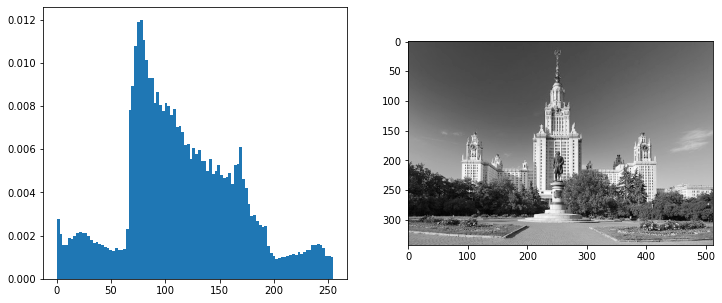

In [13]:
lin_stretch_img = 255 * (gray_f32 - gray_f32.min()) / (gray_f32.max() - gray_f32.min())

plot_image_with_hist(lin_stretch_img)

Как ещё мы можем повысить контрастность изображения? Чтобы сгладить резкие углы, используется эквивализация гистограммы. Алгоритм для выравнивания гистограммы цветов. 

### Histogram equalization

Как найти такое преобразование? Трюк тот же, что и при сэмплировании случайных чисел для разнообразных распределений с использованием функции распределения $F(x)$. Ответом является отображение значений пикселей в соответствующие им квантили. 

Почему?
> После такого преобразования кумилятивная функция распределения итоговых значений $F(x)$ в идеальной картине мира без квантизации будет $$F(x) = x.$$
Следовательно плотность распределения пикселов, по-другому гистограмма цветов, будет равномерной.

Алгоритм:
1. Посчитать гистограмму цветов h
2. Посчитать префиксные суммы массива h, оно и есть CDF(cumulative distribution function) цветов картинки
3. Чтобы получить картинку с линеаризованной CDF используем трансформацию пикселов по правилу: $ y = CDF(x) $, где $ x \in [0; 255] $, чтобы получить квантиль для исходного значения пикселя x.

Подробнее об алгоритме можно почитать на wiki [Histogram_equalization](https://en.wikipedia.org/wiki/Histogram_equalization#Implementation)

In [10]:
def calculate_cdf(gray_image):
    """
    gray_image - dtype=int/uint
    """
    hist, _ = np.histogram(np.ravel(gray_image), bins=256, range=[0, 256], density=True)
    cdf = np.cumsum(hist)
    return cdf

def hist_equalization(gray_image):
    # convert to int
    # it's important to add small constant before converting
    gray_image = (255 * gray_image + 0.01).astype('int32')
    
    #get cdf of image
    cdf = calculate_cdf(gray_image)
    
    f = np.vectorize(lambda x: cdf[x])
    
    #map all values to cdf's values
    gray_image = f(gray_image)
    
    return gray_image

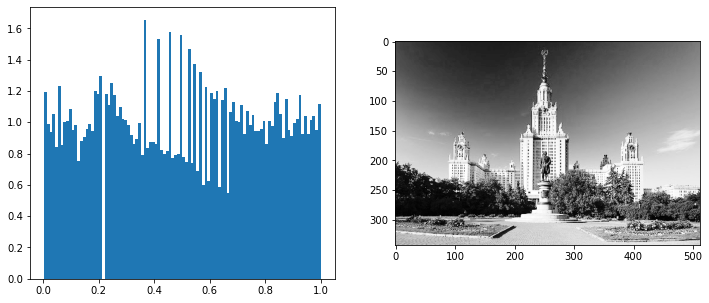

In [11]:
he_f32 = hist_equalization(gray_f32)

plot_image_with_hist(he_f32)

In [12]:
# Тесты
from tests import test_he
test_he(hist_equalization)

---------------
OK, + 1 балл


In [9]:
def plot_triple(images, names):
    plt.figure(figsize=(15, 5))
    for idx, (img, title) in enumerate(zip(images, names)):
        plt.subplot(1, 3, idx + 1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')

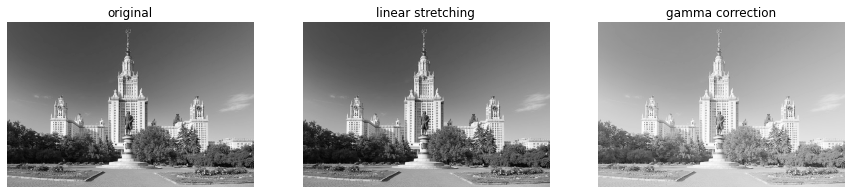

In [10]:
images = [gray_f32, lin_stretch_img, gamma_correction]
names = ['original', 'linear stretching', 'gamma correction']

plot_triple(images, names)

### Свертки изображений

![](conv.png)

Свертками изображений называют преобразования пикселов картинок с учетом региона определенной формы.
$$ g(i, j) =  h(region(i, j)). $$

Самый известный оператор свертки это линейный сверточный фильтр:
$$ g(i, j) = \sum_{k, l} f(i + k, j + l)h(k, l). $$

In [11]:
def conv(image, kernel, *, kernel_size=3, padd=0, fill_mode='reflect'):
    """
    kernel - arbitrary function with one argument - window
    fill_mode - 'constant', 'symmetric', 'reflect'
    """
    if padd:
        padding = ((padd, padd), (padd, padd))
        if len(image.shape) == 3:
            padding += ((0, 0),)    
        # use np.pad for image padding
        image = np.pad(image, padding, fill_mode)
        
    #define new image
    new_image = []
    
    shift = kernel_size // 2
    
    for i in tqdm(range(shift, image.shape[0] - shift), total=image.shape[0] - 2 * shift):
        #create line
        line = []
        for j in range(shift, image.shape[1] - shift):
            #define image slice - window
            window = ...
            #use kernel for window convolution
            ...
            # add value to line
            ...
        #add line to new image
        ...
    
    return np.array(new_image)

In [12]:
# Тесты
from tests import test_conv
test_conv(conv)


---------------
OK, + 1 балл


### Locally adaptive histogram equalization

Глобальная гистограмма цветов может быть очень полезной, но в то же время для некоторых картинок предпочтительней применить различного вида эквивализации к разным регионам. Добиться этого можно с помощью разбиения картинки на блоки размера $(M, M)$ и применить $HE$ независимо для каждого блока. Если блоки будут не пересекаться, то в картинке могут появиться артефакты. 

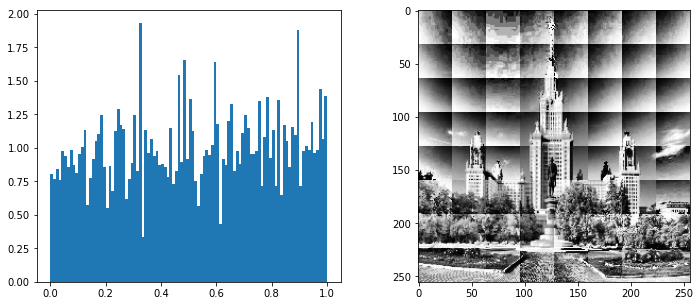

In [13]:
from skimage.transform import resize

resize_f32 = resize(gray_f32, (256, 256))

non_overlapping_f32 = np.zeros_like(resize_f32)

ylen = 32
xlen = 32

for i in range(256 // ylen):
    y = ylen * i
    for j in range(256 // xlen):
        x = xlen * j
        # define slice 'cut'
        cut = ...
        # equalize his of 'cut'
        cut = hist_equalization(cut)
        # fill buffer
        non_overlapping_f32[y:y+ylen, x:x+xlen] = ...
        
plot_image_with_hist(non_overlapping_f32)

Чтобы избежать таких артефактов, можно использовать движущееся окно, а именно рассчитывать гистограммы для каждого блока $(M, M)$ и менять значение только в его центре. Похоже ли это на операцию свертки? Определенно. Поэтому давайте реализуем алгоритм через наш шаблон для свертки.

![](ahe3.png)

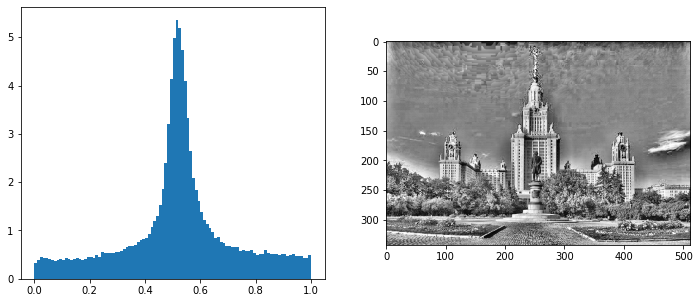

In [14]:
def lahe_kernel(window):
    h, w = window.shape[:2]
    # convert to int
    
    window = (255 * window + 0.1).astype('int32')
    
    #calculate cdf of image's color histogram
    ...
    
    #use value at the center of window only
    return ...
    

lahe_f32 = conv(gray_f32, lahe_kernel, kernel_size=51, padd=25, fill_mode='reflect')

plot_image_with_hist(lahe_f32)

In [15]:
# Тесты
from tests import test_lahe
test_lahe(conv, lahe_kernel)


---------------
OK, + 1 балл


### Шум

Цифровой шум - это дефект изображения, вносимый фотосенсорами и электроникой устройств(как черно-белые телевизоры портили нам яркость) из-за несовершенства технологий или фотонной природы света. Некоторые виды шумов можно промоделировать и использовать для контроля качества алгоритмов понижения уровня шума на картинке. Например, гауссовским шумом на изображении называется колебание яркости распределенное по нормальному закону. 

### Drop-out noise

Или по-другому потеря информации. Соль и перец - случайные черные и белые пиксели, а только белые - импульсивный.

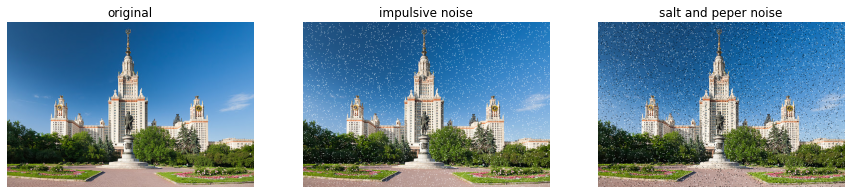

In [16]:
def sample_idx(h, w, count=500):
    y = np.random.randint(h, size=count)
    x = np.random.randint(w, size=count)
    return y, x

def dropout_values(image, val, count=500):
    image = image.copy()
    image[sample_idx(*image.shape[:2], count=count)] = val
    return image

def salt_pepper(image, count=5000):
    # random white and black pixels
    return dropout_values(dropout_values(image, 1, count=count), 0, count=count)

#only white pixels
impulsive_f32 = dropout_values(img_f32, 1, count=5000)
#plus dark
salt_peper_f32 = salt_pepper(img_f32)

images = [img_f32, impulsive_f32, salt_peper_f32]
names = ['original', 'impulsive noise', 'salt and peper noise']

plot_triple(images, names)

### Median filter

Медианный фильт - один из нелинейных фильтров, используемых для уменьшения уровня шума в изображении. Результатом преобразования одного региона является медиана его чисел. 

In [17]:
def median_filter(window):
    #sort values
    ...
    #choice mid value
    ...
    return val

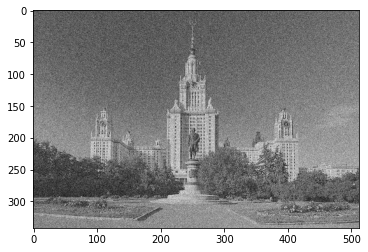

In [18]:
noisy_f32 = gray_f32 + np.random.randn(*gray_f32.shape) * 0.1
plt.imshow(noisy_f32, cmap='gray')
plt.show()

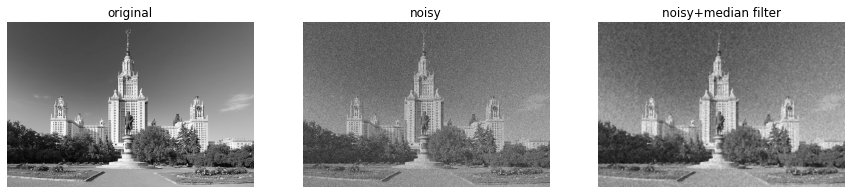

In [19]:
images = [gray_f32, noisy_f32, conv(noisy_f32, median_filter, kernel_size=3, padd=1)]
names = ['original', 'noisy', 'noisy+median filter']


plot_triple(images, names)

In [20]:
# Тесты
from tests import test_median
test_median(conv, median_filter)


---------------
OK, + 1 балл


### Границы объектов

Основной целью обнаружения резких изменений яркости изображения является фиксация важных событий и изменений мира. Они могут отражать различные предположения о модели формирования изображения, изменения в яркости изображения могут указывать на:

> изменения глубины;

> изменения ориентации поверхностей;

> изменения в свойствах материала;

> различие в освещении сцены.

В идеальном случае результатом выделения границ является набор связанных кривых, обозначающих границы объектов. Таким образом, применение фильтра выделения границ к изображению может существенно уменьшить количество обрабатываемых данных из-за того, что отфильтрованная часть изображения считается менее значимой, а наиболее важные структурные свойства изображения сохраняются.

Один из самых простых методов выделения границ - оператор Собеля.

![](sobel.png)


![](grad_norm.png)

In [21]:
sobel_kernel = np.array(
    [
        [1., 2., 1.],
        [0., 0., 0.],
        [-1., -2., -1.]
    ]
)

def sobel_x(window):
    ...
    
def sobel_y(window):
    ...

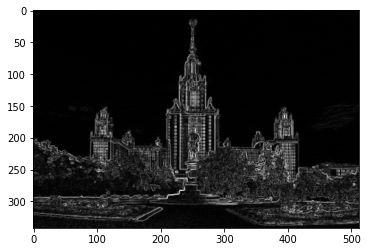

In [22]:
def sobel(gray_image):
    der_x = conv(gray_image, sobel_x, kernel_size=3, padd=1, fill_mode='reflect')
    der_y = conv(gray_image, sobel_y, kernel_size=3, padd=1, fill_mode='reflect')

    edge = ...
    return edge

edge = sobel(gray_f32)

plt.imshow(edge, cmap='gray')
plt.show()

In [23]:
# Тесты
from tests import test_sobel
test_sobel(sobel)


---------------
OK, + 1 балл


### Max filter

In [24]:
def max_filter(window):
    # return max-value among height and width
    return ...

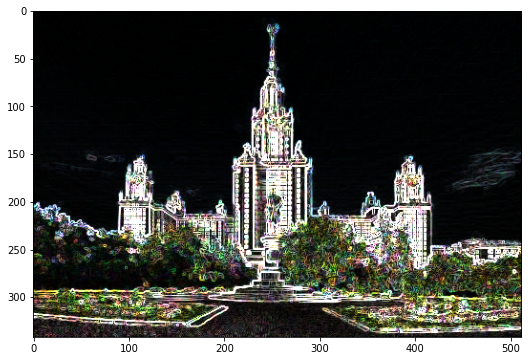

In [25]:
plt.figure(figsize=(10, 6))

noise_f32 = img_f32 + 0.5 * np.random.randn(*img_f32.shape)
median_f32 = conv(noise_f32, median_filter, kernel_size=5, padd=2)
max_f32 = conv(median_f32, max_filter, kernel_size=5, padd=2)

res = edge[:, :, None] * max_f32

plt.imshow(res.clip(0, 1))

plt.show()

In [26]:
# Тесты
from tests import test_max
test_max(conv, max_filter)


---------------
OK, + 1 балл
